count distributions

In [1]:
import os
import gzip
import sys
import pyBigWig
import numpy as np

In [2]:
tfToBed = {}
tfToBed["cbf1"] = "data/cbf1/old_peaks/1000_around_summits.bed.gz"
tfToBed["fixed_cbf1"] = "data/cbf1/1000_around_summits.bed.gz"
tfToBed["pho4"] = "data/pho4/1000_around_summits.bed.gz"

In [3]:
tfToBigWigs = {}
tfToBigWigs["cbf1"] = (pyBigWig.open("data/cbf1/pos_strand.bw"),
                       pyBigWig.open("data/cbf1/neg_strand.bw"))
tfToBigWigs["fixed_cbf1"] = (pyBigWig.open("data/cbf1/pos_strand.bw"),
                             pyBigWig.open("data/cbf1/neg_strand.bw"))
tfToBigWigs["pho4"] = (pyBigWig.open("data/pho4/pos_strand.bw"),
                       pyBigWig.open("data/pho4/neg_strand.bw"))

In [4]:
tfToCounts = {}
tfToCounts["cbf1"] = ([],[])
tfToCounts["fixed_cbf1"] = ([],[])
tfToCounts["pho4"] = ([],[])

In [5]:
for key in tfToBed.keys():
    with gzip.open(tfToBed[key],'rt') as f:
        for line in f:
            chrm, start, end, _ = line.rstrip().split('\t')
            posvals = np.array(tfToBigWigs[key][0].values(chrm, int(start), int(end)))
            where_are_NaNs = np.isnan(posvals)
            posvals[where_are_NaNs] = 0.0
            tfToCounts[key][0].append(np.sum(posvals))
            negvals = np.array(tfToBigWigs[key][1].values(chrm, int(start), int(end)))
            where_are_NaNs = np.isnan(negvals)
            negvals[where_are_NaNs] = 0.0
            tfToCounts[key][1].append(np.sum(np.abs(negvals)))

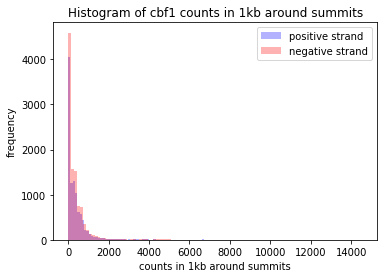

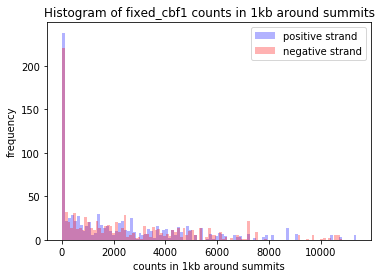

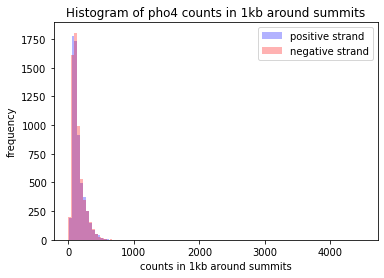

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline  

num_bins = 100
for key in tfToBed.keys():
    plt.hist(tfToCounts[key][0], num_bins, facecolor='blue', alpha=0.3, label='positive strand')    
    plt.hist(tfToCounts[key][1], num_bins, facecolor='red', alpha=0.3, label='negative strand')
    plt.xlabel('counts in 1kb around summits')
    plt.ylabel('frequency')
    plt.title(r'Histogram of '+key+' counts in 1kb around summits')
    plt.legend(loc='upper right')
    plt.subplots_adjust(left=0.15)
    plt.show()

In [7]:
bound = 1000
tfToCounts_bounded = {}
for key in tfToBed.keys():
    tfToCounts_bounded[key] = ([],[])
for key in tfToBed.keys():
    for val0, val1 in zip(tfToCounts[key][0], tfToCounts[key][1]):
        if val0 > bound or val1 > bound:
            continue
        tfToCounts_bounded[key][0].append(val0)
        tfToCounts_bounded[key][1].append(val1)

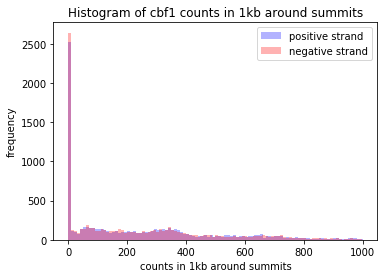

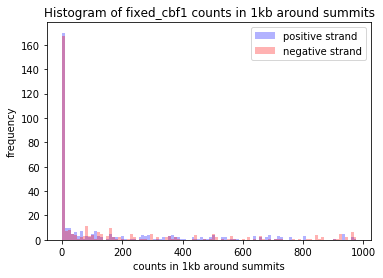

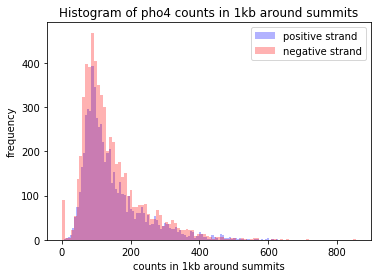

In [8]:
for key in tfToBed.keys():
    plt.hist(tfToCounts_bounded[key][0], num_bins, facecolor='blue', alpha=0.3, label='positive strand')    
    plt.hist(tfToCounts_bounded[key][1], num_bins, facecolor='red', alpha=0.3, label='negative strand')
    plt.xlabel('counts in 1kb around summits')
    plt.ylabel('frequency')
    plt.title(r'Histogram of '+key+' counts in 1kb around summits')
    plt.legend(loc='upper right')
    plt.subplots_adjust(left=0.15)
    plt.show()

Footprinting

In [9]:
fastapath = "sacCer3.genome.fa"
GenomeDict={}
sequence=''
inputdatafile = open(fastapath)
for line in inputdatafile:
    if line[0]=='>':
        if sequence != '':
            GenomeDict[chrm] = ''.join(sequence)
        chrm = line.strip().split('>')[1]
        sequence=[]
        Keep=False
        continue
    else:
        sequence.append(line.strip())
GenomeDict[chrm] = ''.join(sequence)

In [10]:
chrm_sizes = {}
for chrm in GenomeDict.keys():
    chrm_sizes[chrm]=len(GenomeDict[chrm])

In [11]:
totalNumPeaks = {}
totalNumPeaks["cbf1"] = 10449
totalNumPeaks["fixed_cbf1"] = 917
totalNumPeaks["pho4"] = 6086

In [12]:
import re

width = 250
posFootprint = {}
negFootprint = {}
motif = "CACGTG"
for key in tfToBed.keys():
    print(key)
    numInstances = 0
    peaksContainingMotif = 0
    posFootprint[key] = np.zeros((2*width,))
    negFootprint[key] = np.zeros((2*width,))
    with gzip.open(tfToBed[key],'rt') as f:
        for line in f:
            chrm, start, end, _ = line.rstrip().split('\t')
            sequence = GenomeDict[chrm][int(start):int(end)].upper()
            matches = [int(start)+m.start()+3 for m in re.finditer(motif, sequence)]
            if len(matches) != 0:
                peaksContainingMotif += 1
            for coord in matches:
                if coord-width<0 or coord+width>=chrm_sizes[chrm]:
                    continue
                numInstances += 1
                posvals = np.array(tfToBigWigs[key][0].values(chrm, coord-width, coord+width))
                where_are_NaNs = np.isnan(posvals)
                posvals[where_are_NaNs] = 0.0
                posFootprint[key] += posvals
                negvals = np.array(tfToBigWigs[key][1].values(chrm, coord-width, coord+width))
                where_are_NaNs = np.isnan(negvals)
                negvals[where_are_NaNs] = 0.0
                negFootprint[key] += negvals
    posFootprint[key] = posFootprint[key]/float(numInstances)
    negFootprint[key] = negFootprint[key]/float(numInstances)
    print("number of peaks with motifs: ", peaksContainingMotif)
    print("total number of peaks: ", totalNumPeaks[key])
    print("fraction of peaks with motifs: ", peaksContainingMotif/float(totalNumPeaks[key]))
    print("total number of motif instances: ", numInstances)

cbf1
number of peaks with motifs:  1372
total number of peaks:  10449
fraction of peaks with motifs:  0.13130443104603312
total number of motif instances:  1556
fixed_cbf1
number of peaks with motifs:  607
total number of peaks:  917
fraction of peaks with motifs:  0.6619411123227917
total number of motif instances:  846
pho4
number of peaks with motifs:  1763
total number of peaks:  6086
fraction of peaks with motifs:  0.28968123562274073
total number of motif instances:  1952


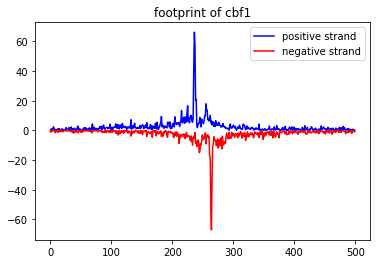

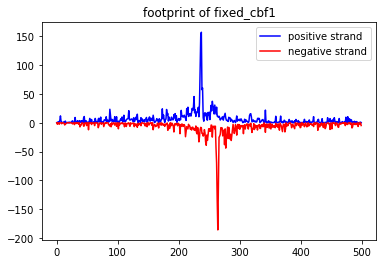

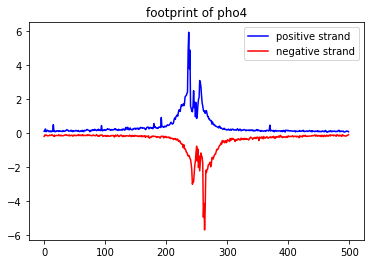

In [13]:
for key in tfToBed.keys():
    t = range(2*width)
    plt.plot(t, posFootprint[key], 'b', label='positive strand') 
    plt.plot(t, negFootprint[key], 'r', label='negative strand')
    plt.title(r'footprint of '+key)
    plt.legend(loc='upper right')
    plt.show()

Footprinting across same set

In [14]:
def readChromSizes(chrom_sizes_file):
    chrom_size_list = []
    for line in open(chrom_sizes_file):
        (chrom, size) = line.rstrip().split("\t")[0:2]
        chrom_size_list.append((chrom,int(size)))
    return chrom_size_list

In [15]:
chrms = ["chrI","chrII","chrIII","chrIV","chrV","chrVI","chrVII","chrVIII",
         "chrIX","chrX","chrXI","chrXII","chrXIII","chrXIV","chrXV","chrXVI","chrM"]

In [16]:
def customChromSizeSort(c):
    return chrms.index(c[0])

In [17]:
from pyfaidx import Fasta
genome_object = Fasta("sacCer3.genome.fa")

chrom_sizes = readChromSizes("sacCer3.chrom.sizes")
chrom_sizes.sort(key=customChromSizeSort)

In [18]:
num_chroms = len(chrom_sizes)

fasta_sequences = []
for chrom in chrom_sizes:
    chrom_num = chrom[0]
    chrom_size = chrom[1]
    fasta_sequences.append(genome_object[chrom_num][0:chrom_size].seq)

In [19]:
import re
p = re.compile("CACGTG")

pho4_motif_list = []
for idx in range(len(fasta_sequences)):
    for m in p.finditer(fasta_sequences[idx].upper()):
        pho4_motif_list.append((chrms[idx],int(m.start())))

In [20]:
# do the ranges
region_size = 200
motif_length = 6

range_dict = {}
ranges = []
for idx in range(len(pho4_motif_list)):
    chrom_number = pho4_motif_list[idx][0]
    start = pho4_motif_list[idx][1]-int((region_size/2 - motif_length/2))
    end = pho4_motif_list[idx][1]+int((region_size/2 + motif_length/2-1))
    ranges.append((chrom_number,start,end))
    for num in range(start,end):
        range_dict[chrom_number+str(num)]=0

In [21]:
posFootprint = {}
negFootprint = {}
for key in tfToBed.keys():
    posFootprint[key] = np.zeros((region_size-1,))
    negFootprint[key] = np.zeros((region_size-1,))
    for chrm, start, end in ranges:
        posvals = np.array(tfToBigWigs[key][0].values(chrm, start, end))
        where_are_NaNs = np.isnan(posvals)
        posvals[where_are_NaNs] = 0.0
        posFootprint[key] += posvals
        negvals = np.array(tfToBigWigs[key][1].values(chrm, start, end))
        where_are_NaNs = np.isnan(negvals)
        negvals[where_are_NaNs] = 0.0
        negFootprint[key] += negvals
    posFootprint[key] = posFootprint[key]/float(len(ranges))
    negFootprint[key] = negFootprint[key]/float(len(ranges))

In [22]:
len(ranges)

953

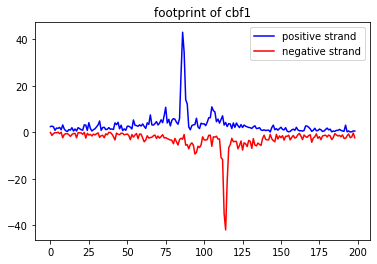

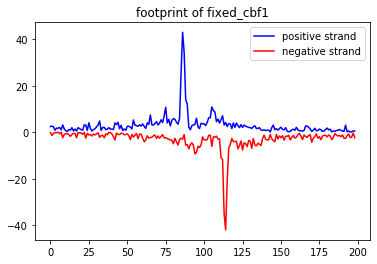

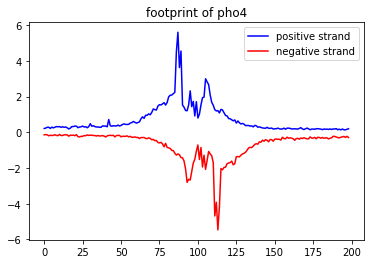

In [23]:
for key in tfToBed.keys():
    t = range(region_size-1)
    plt.plot(t, posFootprint[key], 'b', label='positive strand') 
    plt.plot(t, negFootprint[key], 'r', label='negative strand')
    plt.title(r'footprint of '+key)
    plt.legend(loc='upper right')
    plt.show()